# Introducción

**1 Introducción**

Antes de comenzar es conveniente resaltar algunos supuestos básicos para realizar pronósticos, estos supuestos se basan en el sentido común a la vez de fundamentos teóricos estadísticos.

- El pronóstico se realiza teniendo en cuenta que el mercado y las demás codiciones de mercado se mantienen estables, pues perturbaciones en estos provocarán cambios inesperados que no pudieron modelarse.
- Se acepta un cambio gradual, mas no, uno drástico.
- Eventos como ajustes el política monetaria de los Estados Unidos o cambios geopóliticos, son eventos que requieren una modelización detallada.

**2. Tipos de modelos**

A los modelos construidos se los clasificará dentro de Modelos de Series de Tiempo Univariadas y Multivariadas. Pueden existir muchas mas clasificaciones, pero considero que esta clasificación segun la dimensionalidad del problema representa de buena manera la complejidad que puede tener un modelo.

**3. Evaluación de modelos**

Dado que trabajaremos con datos continuos, es conveniente establecer una métrica que nos permita evaluar la predicción de nuestros modelos.

**3.1 Error Cuadrático Medio**

El Error Cuadrático Medio (MSE) es una de la métricas más utilizadas en el Machine Learning. Esta métrica se calcula como el promedio de los errores al cuadrado:
$$MSE = \frac{1}{n} ∑ \left(y_t - \hat{y}_t \right)^2$$

**3.2 Raiz del Error Cuadrático Medio**

La Raiz del Error Cuadrático Medio (RMSE), es la raiz del Error Cuadrático Medio. La ventaja de sacar esta métrica se debe al hecho de que la raiz cuadrada del MSE es que la escala del RMSE es la misma que la escala de la variable original.
$$RMSE = \sqrt{MSE}$$

**3.3 Error Absoluto Medio**

El Error Absoluto Medio (MAE), toma la diferencia absoluta de los valores reales y los valores pronosticados:
$$MAE = \frac{1}{n} \sum |y_t - \hat{y}_t|$$

**3.4 Error Porcentual Absoluto Medio**
En términos simples, el MAPE calcula el porcentaje promedio de error absoluto entre las predicciones y los valores reales. Cuanto menor sea el MAPE, mejor será la precisión del modelo de predicción. Sin embargo, el MAPE tiene la limitación de ser sensible a los casos en los que los valores reales son cercanos o iguales a cero. En tales casos, el MAPE puede volverse indefinido o infinitamente grande.
$$MAPE =  \frac{1}{n} \sum \left|\frac{y_t - \hat{y}_t}{y_t}\right|$$

**3.5 R2**

El coeficiente de determinación, comúnmente conocido como R2 (R cuadrado), es una métrica estadística que proporciona una medida de la calidad de un modelo de regresión en relación con los datos observados. Es una medida que indica cuánta variabilidad en la variable dependiente puede ser explicada por el modelo.
$$R^2 = 1 - \frac{\sum (y_t - \hat{y}_t)^2}{\sum (y_t - \bar{y}_t)^2}$$


# Pronóstico de Series de Tiempo


In [ ]:
pip install pmdarima

In [ ]:
#Manipulacion y tratamiento de los datos
import numpy as np
import pandas as pd

#Visualizacion de datos
import statsmodels.api as sm
import plotly.express as px
import matplotlib.pyplot as plt
%matplotlib inline

#Modelacion ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller

#Modelacion Auto ARIMA
from pmdarima import auto_arima

#Métrica de evaluacion
from sklearn.metrics import mean_squared_error
from statsmodels.tools.eval_measures import rmse
from sklearn import metrics

#Importar datos desde la API de Yahoo Finance
import yfinance as yf

#No presentar advertencias
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# Es conveniente crear una función para evaluar las métricas, para así no repetir código

def metric_evaluation(y_true, y_pred):
    def mean_absolute_percentaje_error(y_true, y_pred):
        y_true = np.array(y_true)
        y_pred = np.array(y_pred)
        np.mean(np.abs((y_true - y_pred) / y_pred)) *100
        return
    print('Evaluation metric results:')
    print(f'MSE is: {metrics.mean_squared_error(y_true, y_pred)}')
    print(f'MAE is: {metrics.mean_absolute_error(y_true, y_pred)}')
    print(f'RMSE is: {np.sqrt(metrics.mean_squared_error(y_true, y_pred))}')
    print(f'MAPE is: {mean_absolute_percentaje_error(y_true, y_pred)}')
    print(f'R2 is: {metrics.r2_score(y_true, y_pred)}', end='n/n')


In [ ]:
#Importamos los datos de YF
GOOG = yf.download('GOOG', start = '2004-08-19', end = '2024-02-14')
GOOG.head(1)

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2004-08-19,2.490664,2.591785,2.390042,2.499133,2.499133,897427216


In [ ]:
# Convirtamos la fecha (nuestro índice) en un objeto de fecha y hora
GOOG.index = pd.to_datetime(GOOG.index)
GOOG.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4905 entries, 2004-08-19 to 2024-02-13
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       4905 non-null   float64
 1   High       4905 non-null   float64
 2   Low        4905 non-null   float64
 3   Close      4905 non-null   float64
 4   Adj Close  4905 non-null   float64
 5   Volume     4905 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 268.2 KB


In [ ]:
# Usaremos solo la columna de precio de cierre
GOOG_Close = pd.DataFrame(GOOG["Close"])

In [ ]:
#El indice esta correctamente en formato fecha
GOOG_Close.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4905 entries, 2004-08-19 to 2024-02-13
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Close   4905 non-null   float64
dtypes: float64(1)
memory usage: 76.6 KB


In [ ]:
#Gráfico
fig = px.line(GOOG_Close, x = GOOG_Close.index, y = 'Close', title = 'GOOGLE')
fig

# ARIMA


Para usar los modelos de tipo ARIMA necesitamos comprobar que los momentos incondicionales existen, o dicho de otra forma que la serie de tiempo es estacionaria. Observando el anterior gráfico, es posible intuir que el primer momento incondicional no existe, pues parece haber una tendencia.

Sin embargo, no podemos guiarnos por el ojo humnao, por ello lo usual es usar una bateria de test que nos indiquen si la serie presenta o no raices unitarias.

In [ ]:
# Test Dickey Fuller
# Para ello crearemos una función para automatizar el rechazo o no de la Hipotesis Nula
# La Hipotesis Nula es que Existe una raiz unitaria
def augmented_dickey_fuller_test_func(series, column_name):
    print(f'Resultados de la Prueba ADF para la columna: {column_name}')
    dftest = adfuller(series, autolag = 'AIC')
    dfoutput = pd.Series(dftest[0:4], index = ['Test Estatistic', 'P-value', 'No Lags Used', 'Número de observaciones usadas'])
    for key, value in dftest[4].items():
        dfoutput['Critical Value (%s)' %key] = value
    print (dfoutput)
    if dftest[1] <= 0.05:
        print('Conclusión:')
        print('Rechazar la Hipótesis Nula')
        print('Los datos son estacionarios')
    else:
        print('Conclusión:')
        print('No se Rechaza la Hipótesis Nula')
        print('Los datos no son estacionarios')

In [ ]:
augmented_dickey_fuller_test_func(GOOG_Close['Close'], 'Close')

Resultados de la Prueba ADF para la columna: Close
Test Estatistic                      1.357598
P-value                              0.996913
No Lags Used                        31.000000
Número de observaciones usadas    4873.000000
Critical Value (1%)                 -3.431693
Critical Value (5%)                 -2.862133
Critical Value (10%)                -2.567086
dtype: float64
Conclusión:
No se Rechaza la Hipótesis Nula
Los datos no son estacionarios


In [ ]:
#Como los datos son de frecuencia diaria, no hay necesidad de saber si tiene un componente estacional

#plt.rcParams['figure.figsize'] = (12,8)
#a = seasonal_decompose(GOOG_Close['Close'], model = 'add')
#a.plot()

Ejecutamos la función auto_arima() para obtener los valores (p,d,q)

In [ ]:
# Observaciones:
# m se relaciona con el ciclo estacional, diario: m=7, semanal: m=52, mensual: m=12, año: m=1

auto_arima(GOOG_Close['Close'], start_p=0, d=1, start_q=0, max_p=3, max_d=1, max_q=3,
                                start_P=0, D=1, start_Q=0, max_P=3, max_D=1, max_Q=3,
                                m=7, seasonal=True,
                                error_action='warn', trace=True, supress_warnings=True,
                                stepwise=True, random_state=20, n_filts=50, information_criterion='bic')

Performing stepwise search to minimize bic
 ARIMA(0,1,0)(0,1,0)[7]             : BIC=17987.670, Time=0.26 sec
 ARIMA(1,1,0)(1,1,0)[7]             : BIC=16641.744, Time=1.12 sec
 ARIMA(0,1,1)(0,1,1)[7]             : BIC=inf, Time=5.72 sec
 ARIMA(1,1,0)(0,1,0)[7]             : BIC=17995.579, Time=0.43 sec
 ARIMA(1,1,0)(2,1,0)[7]             : BIC=16052.212, Time=1.99 sec
 ARIMA(1,1,0)(3,1,0)[7]             : BIC=15762.858, Time=3.25 sec
 ARIMA(1,1,0)(3,1,1)[7]             : BIC=inf, Time=34.79 sec
 ARIMA(1,1,0)(2,1,1)[7]             : BIC=inf, Time=13.27 sec
 ARIMA(0,1,0)(3,1,0)[7]             : BIC=15755.111, Time=2.77 sec
 ARIMA(0,1,0)(2,1,0)[7]             : BIC=16043.898, Time=1.38 sec
 ARIMA(0,1,0)(3,1,1)[7]             : BIC=inf, Time=25.59 sec
 ARIMA(0,1,0)(2,1,1)[7]             : BIC=inf, Time=10.38 sec
 ARIMA(0,1,1)(3,1,0)[7]             : BIC=15762.869, Time=3.39 sec
 ARIMA(1,1,1)(3,1,0)[7]             : BIC=15767.011, Time=10.48 sec
 ARIMA(0,1,0)(3,1,0)[7] intercept   : BIC=15

ARIMA(order=(0, 1, 0), scoring_args={}, seasonal_order=(3, 1, 0, 7),
      suppress_warnings=True, with_intercept=False)

El mejor modelo, basado en el criterio de información Bayesiano (BIC), es un ARIMA(0,1,0)(3,1,0)

## División de los datos en entrenamiento y prueba

In [ ]:
#Dividimos el conjunto de datos en entrenamiento (80%) y prueba (20%)
to_row =int(len(GOOG_Close)*0.8)
to_row

3924

In [ ]:
train_data = GOOG_Close[0:to_row]
test_data = GOOG_Close[to_row:]

In [ ]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3924 entries, 2004-08-19 to 2020-03-20
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Close   3924 non-null   float64
dtypes: float64(1)
memory usage: 61.3 KB


In [ ]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 981 entries, 2020-03-23 to 2024-02-13
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Close   981 non-null    float64
dtypes: float64(1)
memory usage: 15.3 KB


In [ ]:
#instanciamos la clase y utilzamos sus métodos
#trend= [0,0]  --- y(t) = A(0) + A(1)t + A(2)t^2
#Best model:  ARIMA(0,1,0)(3,1,0)[7]
arima_model = SARIMAX(train_data, order = (0,1,0), seasonal_order=(3,1,0,7))
arima_result = arima_model.fit()
print(arima_result.summary())

                                     SARIMAX Results                                     
Dep. Variable:                             Close   No. Observations:                 3924
Model:             SARIMAX(0, 1, 0)x(3, 1, 0, 7)   Log Likelihood               -3186.784
Date:                           Wed, 14 Feb 2024   AIC                           6381.569
Time:                                   05:31:33   BIC                           6406.660
Sample:                                        0   HQIC                          6390.473
                                          - 3924                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L7       -0.6898      0.008    -89.072      0.000      -0.705      -0.675
ar.S.L14      -0.4980      0.009    -53.833

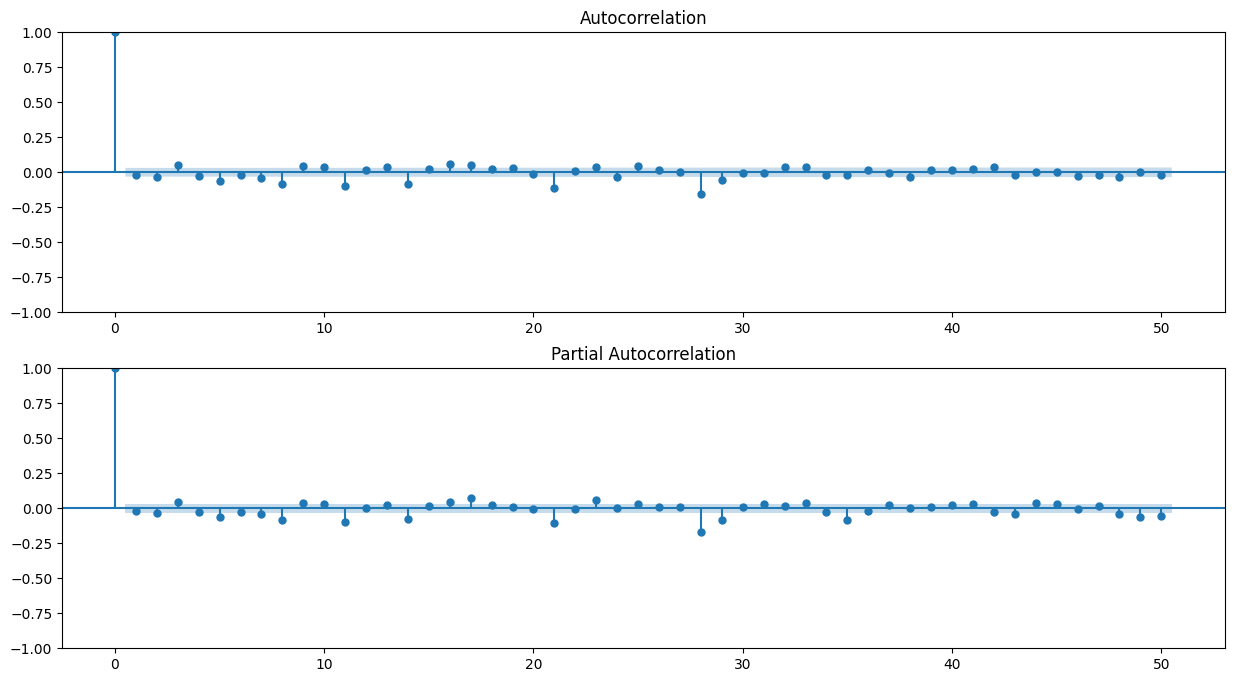

In [ ]:
# Observamos si los residuos son Ruido Blanco
res = arima_result.resid
fig,ax = plt.subplots(2,1,figsize=(15,8))
fig = sm.graphics.tsa.plot_acf(res, lags=50, ax=ax[0])
fig = sm.graphics.tsa.plot_pacf(res, lags=50, ax=ax[1])
plt.show()

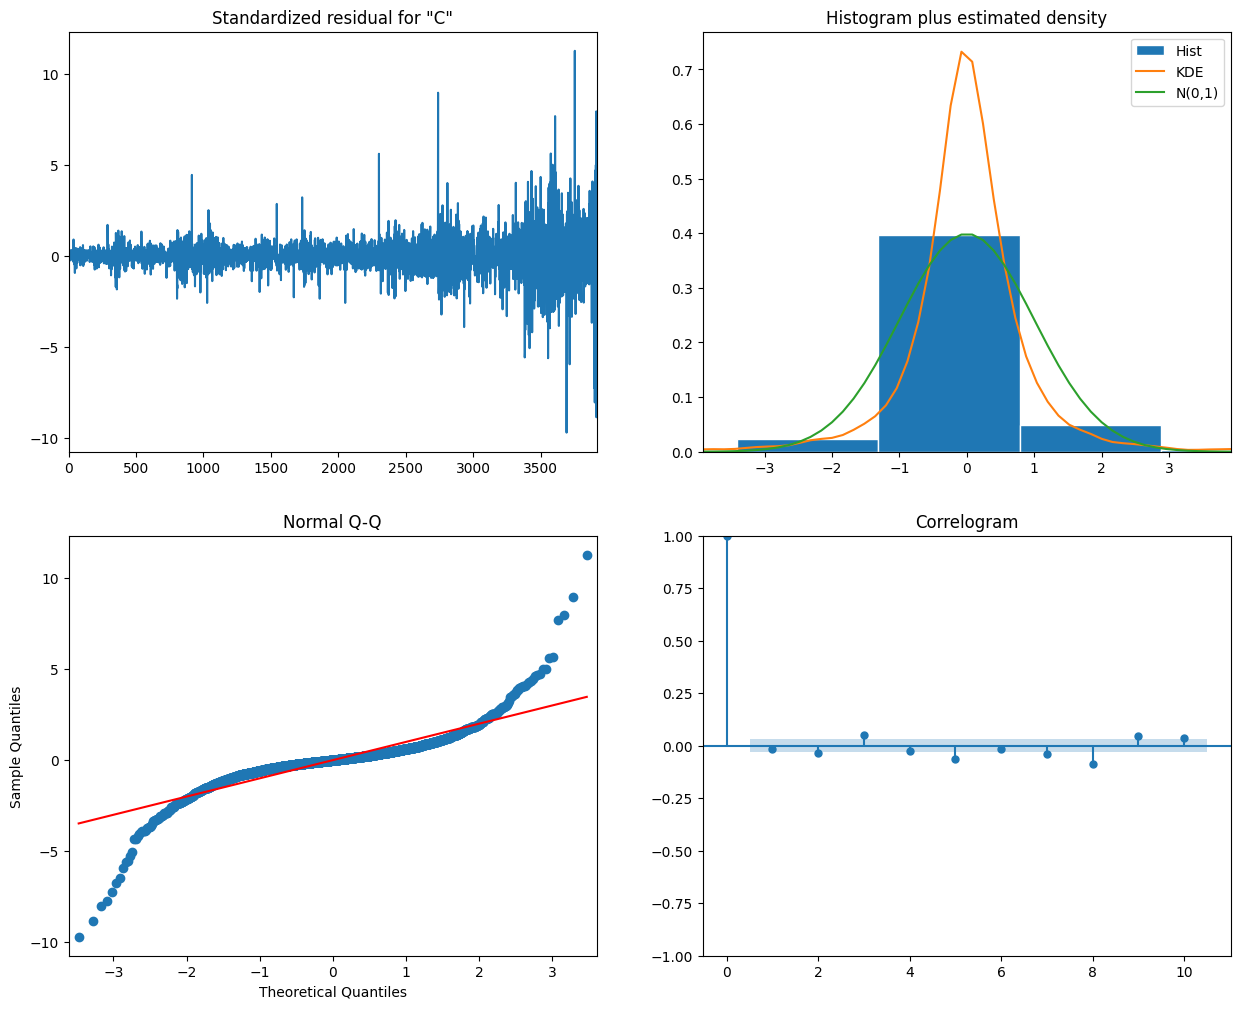

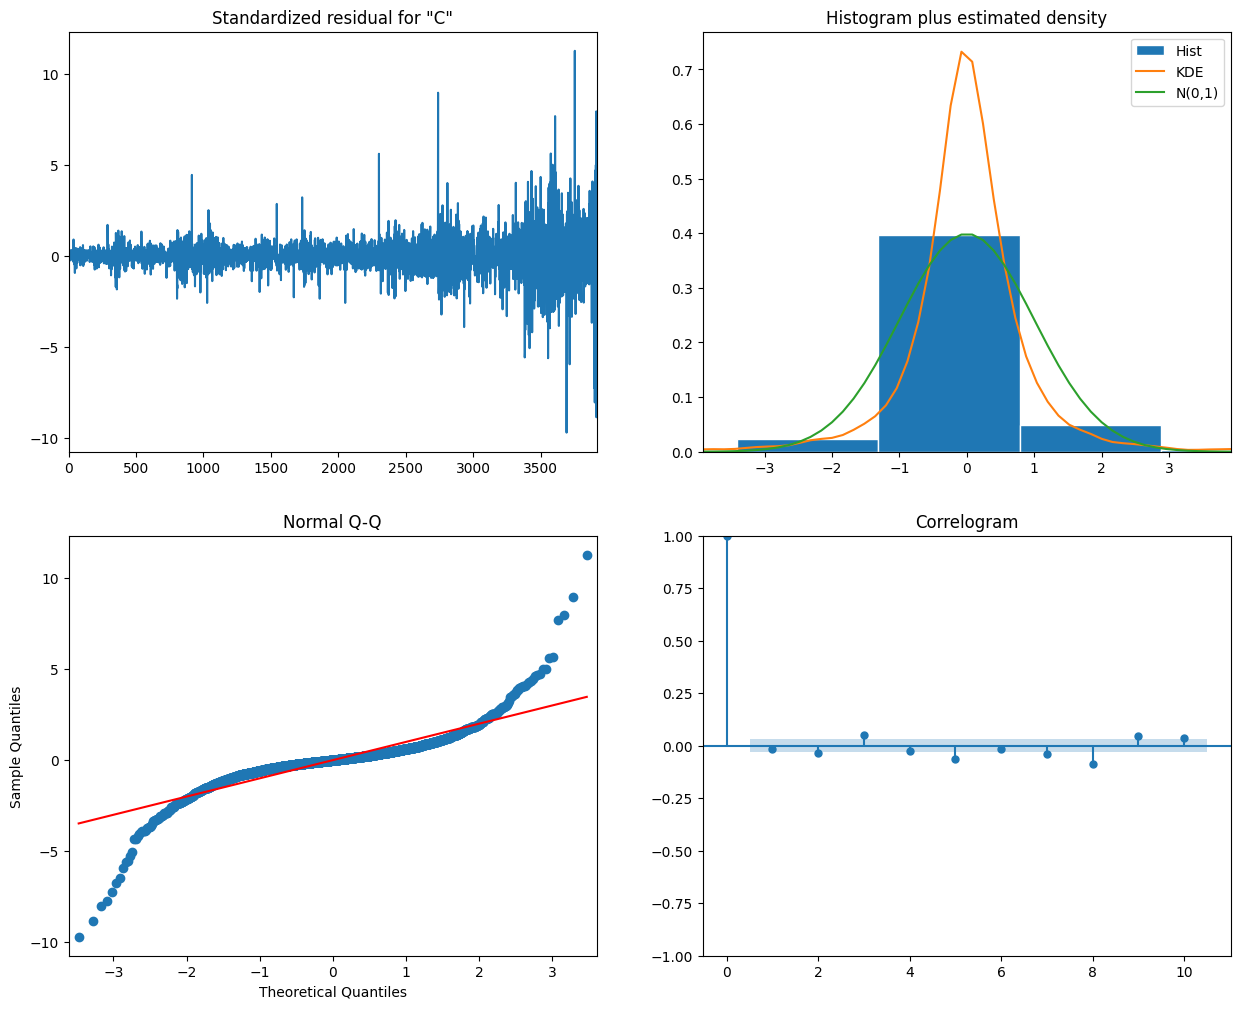

In [ ]:
arima_result.plot_diagnostics(figsize=(15, 12))

In [ ]:
# Predicciones del modelo
# El período de pronóstico de prueba comenzará desde el final del período de entrenamiento.
start = len(train_data)
# y terminará al final de la prueba.
end = len(train_data) + len(test_data) - 1

arima_pred = arima_result.predict(start=start, end=end)
arima_pred

3924     51.232654
3925     52.713305
3926     49.546888
3927     50.035608
3928     48.032429
           ...    
4900   -865.735754
4901   -868.128128
4902   -866.590915
4903   -867.917651
4904   -870.959747
Name: predicted_mean, Length: 981, dtype: float64

In [ ]:
arima_pred.info()

<class 'pandas.core.series.Series'>
RangeIndex: 981 entries, 3924 to 4904
Series name: predicted_mean
Non-Null Count  Dtype  
--------------  -----  
981 non-null    float64
dtypes: float64(1)
memory usage: 7.8 KB


In [ ]:
# No tiene formato fecha, por que?
# Le asignamos nuevamente
arima_pred.index = test_data.index
arima_pred

Date
2020-03-23     51.232654
2020-03-24     52.713305
2020-03-25     49.546888
2020-03-26     50.035608
2020-03-27     48.032429
                 ...    
2024-02-07   -865.735754
2024-02-08   -868.128128
2024-02-09   -866.590915
2024-02-12   -867.917651
2024-02-13   -870.959747
Name: predicted_mean, Length: 981, dtype: float64

In [ ]:
arima_pred.info()

<class 'pandas.core.series.Series'>
DatetimeIndex: 981 entries, 2020-03-23 to 2024-02-13
Series name: predicted_mean
Non-Null Count  Dtype  
--------------  -----  
981 non-null    float64
dtypes: float64(1)
memory usage: 15.3 KB


Text(0.5, 1.0, 'Prediccion con el modelo ARIMA')

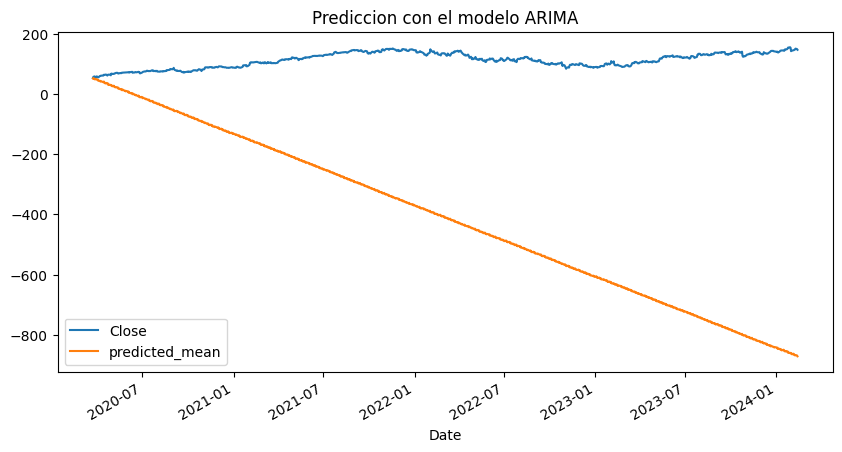

In [ ]:
# Graficamos
test_data['Close'].plot(figsize = (10,5), legend=True)
arima_pred.plot(legend=True)
plt.title('Prediccion con el modelo ARIMA')

In [ ]:
# No dio lo que esperaba
# Evaluamos las metricas de prediccion
metric_evaluation(test_data, arima_pred)

Evaluation metric results:
MSE is: 349790.979419852
MAE is: 520.2677570829322
RMSE is: 591.4312972948354
MAPE is: None
R2 is: -576.2352597467175n/n

# LSTM

## Estandarización

In [ ]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaler.fit(train_data)
scaled_train_data = scaler.transform(train_data)
scaled_test_data = scaler.transform(test_data)

Antes de crear el modelo LSTM, debemos crear un objeto Generador de series temporales

In [ ]:
from keras.preprocessing.sequence import TimeseriesGenerator

n_input = 7
n_features = 1
generator = TimeseriesGenerator(scaled_train_data, scaled_train_data, length=n_input, batch_size=1)

## Modelación

In [ ]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

lstm_model = Sequential()
lstm_model.add(LSTM(200, activation='relu', input_shape=(n_input, n_features)))
lstm_model.add(Dense(1))
lstm_model.compile(optimizer='adam', loss='mse')

print(lstm_model.summary())

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 200)               161600    
                                                                 
 dense_2 (Dense)             (None, 1)                 201       
                                                                 
Total params: 161801 (632.04 KB)
Trainable params: 161801 (632.04 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


In [ ]:
lstm_model.fit_generator(generator, epochs=20)

Epoch 1/20
3917/3917 [==============================] - 79s 19ms/step - loss: 9.5006e-04
Epoch 2/20
3917/3917 [==============================] - 43s 11ms/step - loss: 2.3821e-04
Epoch 3/20
3917/3917 [==============================] - 39s 10ms/step - loss: 1.8613e-04
Epoch 4/20
3917/3917 [==============================] - 40s 10ms/step - loss: 1.5780e-04
Epoch 5/20
3917/3917 [==============================] - 41s 10ms/step - loss: 1.2684e-04
Epoch 6/20
3917/3917 [==============================] - 40s 10ms/step - loss: 1.0617e-04
Epoch 7/20
3917/3917 [==============================] - 40s 10ms/step - loss: 1.0143e-04
Epoch 8/20
3917/3917 [==============================] - 40s 10ms/step - loss: 9.9475e-05
Epoch 9/20
3917/3917 [==============================] - 51s 13ms/step - loss: 9.8878e-05
Epoch 10/20
3917/3917 [==============================] - 72s 18ms/step - loss: 9.2499e-05
Epoch 11/20
3917/3917 [==============================] - 73s 19ms/step - loss: 8.8370e-05
Epoch 12/20
3917/39

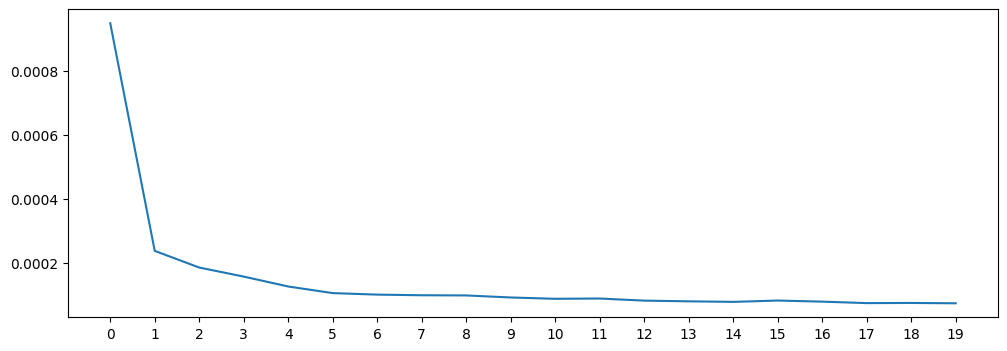

In [ ]:
losses_lstm = lstm_model.history.history['loss']
plt.figure(figsize=(12,4))
plt.xticks(np.arange(0,21,1))
plt.plot(range(len(losses_lstm)), losses_lstm)

In [ ]:
lstm_predictions_scaled = list()
batch = scaled_train_data[-n_input:]
current_batch = batch.reshape((1,n_input, n_features))

for i in range(len(test_data)):
    lstm_pred = lstm_model.predict(current_batch)[0]
    lstm_predictions_scaled.append(lstm_pred)
    current_batch = np.append(current_batch[:,1:,:], [[lstm_pred]], axis=1)

1/1 [==============================] - 0s 37ms/step


Como escalamos los valores, necesitamos invertirlos para que nos de las predicciones correctas

In [ ]:
lstm_predictions_scaled

[array([0.69571984], dtype=float32),
 array([0.69842434], dtype=float32),
 array([0.702086], dtype=float32),
 array([0.7045596], dtype=float32),
 array([0.708603], dtype=float32),
 array([0.7128891], dtype=float32),
 array([0.71751094], dtype=float32),
 array([0.7221383], dtype=float32),
 array([0.726877], dtype=float32),
 array([0.73167443], dtype=float32),
 array([0.7365242], dtype=float32),
 array([0.7413981], dtype=float32),
 array([0.7462958], dtype=float32),
 array([0.7512125], dtype=float32),
 array([0.7561468], dtype=float32),
 array([0.7610965], dtype=float32),
 array([0.7660614], dtype=float32),
 array([0.7710415], dtype=float32),
 array([0.7760365], dtype=float32),
 array([0.7810465], dtype=float32),
 array([0.78607416], dtype=float32),
 array([0.7911252], dtype=float32),
 array([0.7962004], dtype=float32),
 array([0.8012999], dtype=float32),
 array([0.80642426], dtype=float32),
 array([0.8115741], dtype=float32),
 array([0.8167497], dtype=float32),
 array([0.82195127], dtyp

In [ ]:
lstm_predictions = scaler.inverse_transform(lstm_predictions_scaled)
lstm_predictions

array([[53.86536358],
       [54.06507365],
       [54.33546175],
       [54.51812512],
       [54.81670431],
       [55.13320169],
       [55.47449667],
       [55.81619659],
       [56.16611836],
       [56.52037993],
       [56.87850595],
       [57.23841014],
       [57.6000749 ],
       [57.96313931],
       [58.32750655],
       [58.69300935],
       [59.05963891],
       [59.42738644],
       [59.79623432],
       [60.16619135],
       [60.53745121],
       [60.91043643],
       [61.28520862],
       [61.66177659],
       [62.04017556],
       [62.42045833],
       [62.80264251],
       [63.18674572],
       [63.57279435],
       [63.96078841],
       [64.35074551],
       [64.74269204],
       [65.13662802],
       [65.53257985],
       [65.93058274],
       [66.32645535],
       [66.71788252],
       [67.1050227 ],
       [67.48784069],
       [67.86622205],
       [68.24017558],
       [68.6097541 ],
       [68.97501922],
       [69.33601496],
       [69.69280295],
       [70

Guardamos las predicciones para compararlo con los valores reales

In [ ]:
test_data['LSTM_Predictions'] = lstm_predictions
test_data

,Close,LSTM_Predictions
Date,,
2020-03-23,52.831001,53.865364
2020-03-24,56.723000,54.065074
2020-03-25,55.124500,54.335462
2020-03-26,58.087502,54.518125
2020-03-27,55.535500,54.816704
...,...,...
2024-02-07,146.679993,89.368730
2024-02-08,147.220001,89.368730
2024-02-09,150.220001,89.368730


In [ ]:
#Graficamos
ai=test_data[['Close', 'LSTM_Predictions']]
fig = px.line(ai, x=test_data.index, y=ai.columns, title='Prediccion con el Modelo LSTM')
fig.show()

In [ ]:
# Evaluamos las metricas de prediccion
metric_evaluation(test_data['Close'], test_data['LSTM_Predictions'])

Evaluation metric results:
MSE is: 1065.1311114962539
MAE is: 26.3567970116887
RMSE is: 32.63634647898343
MAPE is: None
R2 is: -0.7577103755750996n/n

# Random Forest

In [ ]:
#Realizamos una copia de nuestro dataset
GOOG_Close_Cop= GOOG_Close.copy()

In [ ]:
GOOG_Close_Cop

,Close
Date,
2004-08-19,2.499133
2004-08-20,2.697639
2004-08-23,2.724787
2004-08-24,2.611960
2004-08-25,2.640104
...,...
2024-02-07,146.679993
2024-02-08,147.220001
2024-02-09,150.220001


In [ ]:
GOOG_Close_Cop.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4905 entries, 2004-08-19 to 2024-02-13
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Close   4905 non-null   float64
dtypes: float64(1)
memory usage: 76.6 KB
